# Bonus1: Parallel Algorithms : Federated averaging


### Name: Harman Singh 


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.06034213  0.07530705 -0.04554145 -0.05311129 -0.10580289 -0.13894491
  -0.10045342  0.25612103]]
test std = 
[[0.95383154 1.02465575 0.96460828 1.10572517 0.82171114 0.95654743
  0.77557865 1.17251885]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# Federated Averaging

## 2.1 Define Worker Class


In [45]:
import numpy

# Class defining a worker node
class Worker:
    def __init__(self, x, y, q, batch_size, alpha, beta, lam):
        self.x = x # s x d local feature matrix
        self.y = y # s x 1 local label matrix
        self.s = x.shape[0] # number of local samples
        self.d = x.shape[1] # number of features
        self.q = q # number of local iterations
        self.lam = lam
        self.v = numpy.zeros((self.d,1)) # d x 1 
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta
        
        if 0 != batch_size:
            # split into batches
            self.x_batch=self.x[:self.x.shape[0]-(self.x.shape[0]%self.batch_size),:]
            self.y_batch=self.y[:self.y.shape[0]-(self.y.shape[0]%self.batch_size),:]
            
            self.x_batch = numpy.array(self.x_batch).reshape((int(self.x_batch.shape[0]/self.batch_size), self.batch_size, self.x_batch.shape[1]))
            self.y_batch = numpy.array(self.y_batch).reshape((int(self.y_batch.shape[0]/self.batch_size), self.batch_size, self.y_batch.shape[1]))
        else:
            self.x_batch = self.x
            self.y_batch = self.y
        
        self.w = numpy.zeros((self.d,1)) # d x 1 model parameter vector
        
    def set_param(self, w):
        self.w = w
        
    # compute local loss
    def loss(self, temp_w):
        yx = numpy.multiply(self.y_batch, self.x_batch) # s x d
        yxw = numpy.dot(yx, temp_w) # s x 1
        vec1 = numpy.exp(-yxw) # s-by-1
        vec2 = numpy.log(1+vec1) # s-by-1
        return numpy.sum(vec2)
        
    # compute local gradient
    def gradient(self, y, x, temp_w):
        yx = numpy.multiply(y, x) # s-by-d
        yxw = numpy.dot(yx, temp_w) # s-by-1
        vec1 = numpy.exp(yxw) # s-by-1
        vec2 = numpy.divide(yx, 1+vec1) # s-by-d
        g = -numpy.sum(vec2, axis=0).reshape(self.d, 1) # d-by-1
        return g
    
    def agd(self, g, temp_w):
        self.v *= self.beta
        self.v += g
        temp_w -= self.alpha*self.v
        return temp_w
        
    def objective(self, lam, loss, temp_w):
        reg = lam/2 * numpy.sum(temp_w*temp_w)
        self.obj = loss/self.s + reg
        return self.obj
        
    def client_update(self):
        obj_vals=[]
        temp_w = self.w
        for i in range(self.q):
            # evaluate objective function
            local_loss =self.loss(temp_w)
            obj_vals.append(self.objective(self.lam, local_loss, temp_w))
            for j in range(self.y_batch.shape[0]):
                g = self.gradient(self.y_batch[j,:], self.x_batch[j,:], temp_w)
                temp_w = self.agd(g, temp_w)
        return self.w - temp_w, obj_vals

In [46]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## 2.2 Define Server Class



In [47]:
class Server:
    def __init__(self, m, n, d, alpha):
        self.m = m # workers
        self.n = n # training samples
        self.d = d # features
        self.w = numpy.zeros((d,1)) # d x 1 model parameters
        self.g = numpy.zeros((d,1)) # d x 1 gradient
        self.p = numpy.zeros((d,1)) # d x 1 received gradient
        self.loss = 0 # loss function value
        self.obj = 0 # objective function value
        self.alpha = alpha
        
    def broadcast(self):
        return self.w
        
    def aggregate(self, p, losses):
        self.p = numpy.mean(numpy.array(p), axis=0)
        self.loss = sum(losses)
    
    def update_step(self):
        self.w -= self.alpha*self.p
        
    def objective(self, lam):
        reg = lam/2 * numpy.sum(self.w*self.w)
        self.obj = self.loss/self.n + reg
        return self.obj

# 2.3 Simulation Generation

In [48]:
import math

def create_server_workers(m,x,y,q,b,alpha,beta,lam):
    n,d = x.shape
    s = math.floor(n/m)
    server = Server(m,n,d,alpha)
    
    workers = []
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        workers.append(Worker(x[indices,:], y[indices,:],q,b, alpha, beta, lam))
    return server, workers

In [49]:
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

# 3. Start Simulations

## 3.1 Gradient Descent with q=1

In [50]:
m = 4 
q = 1
batch_size = 0
alpha = 1E-4
beta = 0.99
lam = 1E-4

server, workers = create_server_workers(m, x_train, y_train, q, batch_size, alpha, beta, lam)

Starting Simulation

In [51]:
max_epoch = 50

objvals_gd_1 =[]
for t in range(math.floor(max_epoch/q)):
    # step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        
    ps=[]
    losses=[]
    for i in range(m):
        p, obj_val = workers[i].client_update()
        ps.append(p)
        if i == 0:
            for val in obj_val:
                print("Objective function value = " + str(val))
                objvals_gd_1.append(val)
    
    # step 3: aggregate workers' outputs
    server.aggregate(ps, losses)
    server.update_step()   

Objective function value = 0.6931471805599453
Objective function value = 0.5080260322103884
Objective function value = 0.4531026632683581
Objective function value = 0.44533348570888087
Objective function value = 0.44360001210270866
Objective function value = 0.4427181359797863
Objective function value = 0.4426698955024987
Objective function value = 0.4428868570212372
Objective function value = 0.443055886612056
Objective function value = 0.44316645866841237
Objective function value = 0.44325204483344854
Objective function value = 0.4433099474294785
Objective function value = 0.44333765036204204
Objective function value = 0.4433475210620668
Objective function value = 0.4433513276666131
Objective function value = 0.4433533317335204
Objective function value = 0.4433542293108568
Objective function value = 0.4433544950250013
Objective function value = 0.44335460543685634
Objective function value = 0.44335471133612203
Objective function value = 0.4433547847581429
Objective function value = 0

Prediction

In [52]:
# training error
f_train = predict(server.w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training error is ' + str(error_train))

Training error is 0.2203125


In [53]:
# testing error
f_test = predict(server.w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test error is ' + str(error_test))

Test error is 0.2890625


## 3.2 Gradient Descent with q=8

In [54]:
m = 4 
q = 8
batch_size = 0 
alpha = 1E-4
beta = 0.99
lam = 1E-4

server, workers = create_server_workers(m, x_train, y_train, q, batch_size, alpha, beta, lam)

Starting simulation

In [55]:
# Execute Federated Averaging
max_epoch = 50

objvals_gd_8 =[]
for t in range(math.floor(max_epoch/q)):
    # step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        
    # step 2: workers' local computation
    ps=[]
    losses=[]
    for i in range(m):
        p, obj_val = workers[i].client_update()
        ps.append(p)
        if i == 0:
            for val in obj_val:
                print("Objective function value = " + str(val))
                objvals_gd_8.append(val)
    
    # step 3: aggregate workers' outputs
    server.aggregate(ps, losses)
    server.update_step()

Objective function value = 0.6931471805599453
Objective function value = 0.5906031788350308
Objective function value = 0.5017502175412806
Objective function value = 0.45726029297937604
Objective function value = 0.4319614699720779
Objective function value = 0.4154413415136325
Objective function value = 0.40380123676529334
Objective function value = 0.3952192786254188
Objective function value = 0.5103011711987562
Objective function value = 0.48339993692635047
Objective function value = 0.4520362810754041
Objective function value = 0.42894060733520617
Objective function value = 0.4125411902333522
Objective function value = 0.40059091355007237
Objective function value = 0.3917129680550475
Objective function value = 0.38505372781844205
Objective function value = 0.5128530478343504
Objective function value = 0.4843889331626463
Objective function value = 0.45265837844824897
Objective function value = 0.4294200074060247
Objective function value = 0.4129315885824009
Objective function value = 

Prediction

In [56]:
# training error
f_train = predict(server.w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training error is ' + str(error_train))

Training error is 0.2234375


In [57]:
# test error
f_test = predict(server.w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test error is ' + str(error_test))

Test error is 0.3046875


## 3.3 Stochastic Gradient Descent with q=1

In [58]:
m = 4 
q = 1
batch_size = 1 
alpha = 1E-4
beta = 0.99
lam = 1E-4

server, workers = create_server_workers(m, x_train, y_train, q, batch_size, alpha, beta, lam)

Starting Simulation

In [59]:
max_epoch = 50
objvals_sgd_1 =[]

for t in range(math.floor(max_epoch/q)):
    # step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        

    ps=[]
    losses=[]
    for i in range(m):
        p, obj_val = workers[i].client_update()
        ps.append(p)
        if i == 0:
            for val in obj_val:
                print("Objective function value = " + str(val))
                objvals_sgd_1.append(val)
    

    server.aggregate(ps, losses)
    server.update_step() 

Objective function value = 0.6931471805599453
Objective function value = 0.5080260322103884
Objective function value = 0.4531026632683581
Objective function value = 0.44533348570888087
Objective function value = 0.44360001210270866
Objective function value = 0.4427181359797863
Objective function value = 0.4426698955024987
Objective function value = 0.4428868570212372
Objective function value = 0.443055886612056
Objective function value = 0.44316645866841237
Objective function value = 0.44325204483344854
Objective function value = 0.4433099474294785
Objective function value = 0.44333765036204204
Objective function value = 0.4433475210620668
Objective function value = 0.4433513276666132
Objective function value = 0.4433533317335204
Objective function value = 0.4433542293108568
Objective function value = 0.4433544950250013
Objective function value = 0.44335460543685634
Objective function value = 0.443354711336122
Objective function value = 0.44335478475814294
Objective function value = 0.

Prediction

In [60]:
f_train = predict(server.w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2203125


In [61]:
f_test = predict(server.w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.2890625


## 3.4 Stochastic Gradient Descent with q=8

In [62]:
m = 4 
q = 8
batch_size = 1 
alpha = 1E-4
beta = 0.99
lam = 1E-4

server, workers = create_server_workers(m, x_train, y_train, q, batch_size, alpha, beta, lam)

Starting Simulation

In [63]:
max_epoch = 50
objvals_sgd_8 =[]

for t in range(math.floor(max_epoch/q)):
    # step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)

    ps=[]
    losses=[]
    for i in range(m):
        p, obj_val = workers[i].client_update()
        ps.append(p)
        if i == 0:
            for val in obj_val:
                print("Objective function value = " + str(val))
                objvals_sgd_8.append(val)
    
    server.aggregate(ps, losses)
    server.update_step()    

Objective function value = 0.6931471805599453
Objective function value = 0.5906031788350308
Objective function value = 0.5017502175412806
Objective function value = 0.45726029297937604
Objective function value = 0.4319614699720779
Objective function value = 0.4154413415136325
Objective function value = 0.40380123676529334
Objective function value = 0.3952192786254188
Objective function value = 0.5103011711987562
Objective function value = 0.4833999369263503
Objective function value = 0.4520362810754041
Objective function value = 0.42894060733520617
Objective function value = 0.4125411902333522
Objective function value = 0.40059091355007237
Objective function value = 0.3917129680550476
Objective function value = 0.38505372781844205
Objective function value = 0.5128530478343506
Objective function value = 0.4843889331626463
Objective function value = 0.4526583784482491
Objective function value = 0.4294200074060247
Objective function value = 0.4129315885824009
Objective function value = 0.

Prediction

In [64]:
f_train = predict(server.w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2234375


In [65]:
f_test = predict(server.w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.3046875


# Plotting and comparing GD with q=1, GD with q=8, SGD with q=1, and SGD with q=8
 

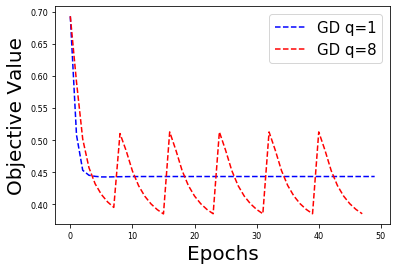

In [82]:

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd_1 = range(len(objvals_gd_1))
epochs_gd_8 = range(len(objvals_gd_8))


line0, = plt.plot(epochs_gd_1, objvals_gd_1, '--b', LineWidth=1.5)
line1, = plt.plot(epochs_gd_8, objvals_gd_8, '--r', LineWidth=1.5)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1], ['GD q=1', 'GD q=8'], fontsize=15)
plt.show()

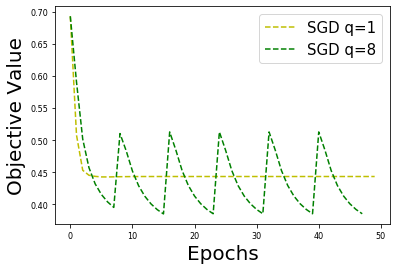

In [87]:
fig = plt.figure(figsize=(6, 4))

epochs_sgd_1 = range(len(objvals_sgd_1))
epochs_sgd_8 = range(len(objvals_sgd_8))

line0, = plt.plot(epochs_sgd_1, objvals_sgd_1, '--y', LineWidth=1.5)
line1, = plt.plot(epochs_sgd_8, objvals_sgd_8, '--g', LineWidth=1.5)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1], [ 'SGD q=1', 'SGD q=8'], fontsize=15)
plt.show()

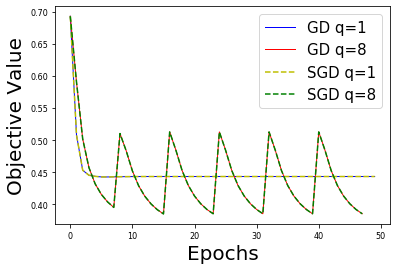

In [88]:
fig = plt.figure(figsize=(6, 4))

epochs_gd_1 = range(len(objvals_gd_1))
epochs_gd_8 = range(len(objvals_gd_8))
epochs_sgd_1 = range(len(objvals_sgd_1))
epochs_sgd_8 = range(len(objvals_sgd_8))

line0, = plt.plot(epochs_gd_1, objvals_gd_1, '-b', LineWidth=1)
line1, = plt.plot(epochs_gd_8, objvals_gd_8, '-r', LineWidth=1)
line2, = plt.plot(epochs_sgd_1, objvals_sgd_1, '--y', LineWidth=1.5)
line3, = plt.plot(epochs_sgd_8, objvals_sgd_8, '--g', LineWidth=1.5)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1, line2, line3], ['GD q=1', 'GD q=8', 'SGD q=1', 'SGD q=8'], fontsize=15)
plt.show()



In [89]:
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=15000)